In [1]:
import os
import pandas as pd
import sqlite3
import requests
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path

ROOT = Path.cwd().parent
load_dotenv(ROOT / '.env')
api_key = os.getenv('EXCHANGE_RATE_API_KEY')

In [13]:
base_currency = "USD"
url_currency_rates = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/{base_currency}"
req_currency = requests.get(url_currency_rates)

data = req_currency.json()

# Extract conversion rates and create DataFrame
conversion_rates = pd.DataFrame(data['conversion_rates'].items(), columns=['Currency_Code', 'Rate'])

# Sort DataFrame by Rate in descending order
highest_rates = conversion_rates.sort_values(by="Rate", ascending=False).reset_index(drop=True)
highest_rates["date"] = data["time_last_update_utc"].split(" 00:")[0]
highest_rates.head()

,Currency_Code,Rate,date
0,LBP,89500.0000,"Sun, 16 Jun 2024"
1,IRR,42108.3265,"Sun, 16 Jun 2024"
2,VND,25416.7614,"Sun, 16 Jun 2024"
3,SLL,22967.6967,"Sun, 16 Jun 2024"
4,LAK,21778.3070,"Sun, 16 Jun 2024"


- **Improvement**: Add country names from this site (quick scraping) https://www.foreignexchangelive.com/currency-codes-symbols/

In [26]:
url_currency_codes = f'https://v6.exchangerate-api.com/v6/{api_key}/codes'
req_codes = requests.get(url_currency_codes)
data_code = req_codes.json()
codes = pd.DataFrame(data_code["supported_codes"], columns=["Currency_Code", "Currency_Name"])

In [2]:
import sqlite3
# Create a sqlite3 database
conn = sqlite3.connect(Path(ROOT / 'data' / 'currency_rates.db'))
c = conn.cursor()

# Query the database, show tables
c.execute('''
SELECT name
FROM sqlite_master
WHERE type='table'
''')

print(c.fetchall())

[('currency_names',), ('currency_rates',), ('sqlite_sequence',)]


- Look at the currency rates tables

In [3]:
currency_rate_df = pd.read_sql_query("SELECT * FROM currency_rates", conn)
currency_rate_df.head()

,id,currency_code,rate,date
0,1,USD,1.0000,"Mon, 03 Jun 2024"
1,2,AED,3.6725,"Mon, 03 Jun 2024"
2,3,AFN,71.2981,"Mon, 03 Jun 2024"
3,4,ALL,92.9346,"Mon, 03 Jun 2024"
4,5,AMD,387.6778,"Mon, 03 Jun 2024"


- Look at the currency names

In [4]:
currency_names_df = pd.read_sql_query("SELECT * FROM currency_names", conn)
currency_names_df.head()

,currency_code,currency_name
0,AED,UAE Dirham
1,AFN,Afghan Afghani
2,ALL,Albanian Lek
3,AMD,Armenian Dram
4,ANG,Netherlands Antillian Guilder


In [24]:
query = '''
SELECT currency_rates.Currency_Code, currency_names.Currency_Name, currency_rates.Rate, currency_rates.date
FROM currency_rates
JOIN currency_names
ON currency_rates.Currency_Code = currency_names.Currency_Code
'''

currency_df = pd.read_sql_query(query, conn)
currency_df.head()

,currency_code,currency_name,rate,date
0,USD,United States Dollar,1.0000,"Mon, 03 Jun 2024"
1,AED,UAE Dirham,3.6725,"Mon, 03 Jun 2024"
2,AFN,Afghan Afghani,71.2981,"Mon, 03 Jun 2024"
3,ALL,Albanian Lek,92.9346,"Mon, 03 Jun 2024"
4,AMD,Armenian Dram,387.6778,"Mon, 03 Jun 2024"


- Some visualizations

C:\Users\mabid\AppData\Local\Temp\ipykernel_13428\4044817629.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  currency_df["date_standard_format"] = pd.to_datetime(currency_df["date"], infer_datetime_format=True)


<Axes: title={'center': 'Euro value in USD'}, xlabel='date_standard_format', ylabel='USD'>

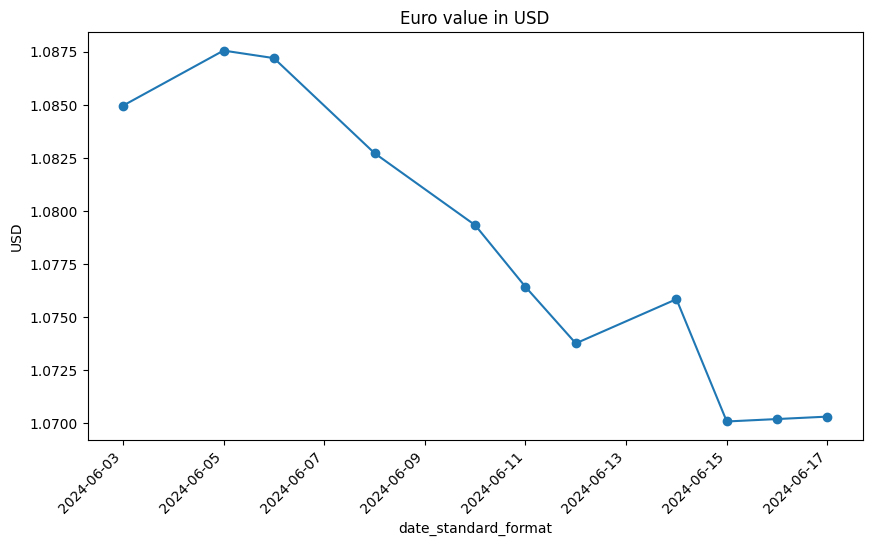

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

currency_df["in_dollars"] = 1 / currency_df["rate"]
# Convert date to DD/MM/YYYY format
currency_df["date_standard_format"] = pd.to_datetime(currency_df["date"], infer_datetime_format=True)

# Rotate the xticks for better readability
currency_df[currency_df["currency_name"].str.contains("Euro")].plot(x="date_standard_format", y="in_dollars", title="Euro value in USD", ylabel="USD", xlabel="date_standard_format", rot=45, marker = "o", legend=False, ax = ax)

In [19]:
min_date, max_date = currency_df["date_standard_format"].min(), currency_df["date_standard_format"].max()
# Set datetime range from min to max date in a dataframe
date_range = pd.date_range(start=min_date, end=max_date, freq="D")
date_range

DatetimeIndex(['2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06',
               '2024-06-07', '2024-06-08', '2024-06-09', '2024-06-10',
               '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14',
               '2024-06-15', '2024-06-16', '2024-06-17'],
              dtype='datetime64[ns]', freq='D')

- Handling missing values (WIP)

First date: 2024-06-03 00:00:00
Last date: 2024-06-17 00:00:00


C:\Users\mabid\AppData\Local\Temp\ipykernel_13428\578268501.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  currency_df["date_standard_format"] = pd.to_datetime(currency_df["date"], infer_datetime_format=True)
C:\Users\mabid\AppData\Local\Temp\ipykernel_13428\578268501.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  complete_df_euro["in_dollars"] = complete_df_euro["in_dollars"].fillna(method="ffill")


(0.0, 1.0)

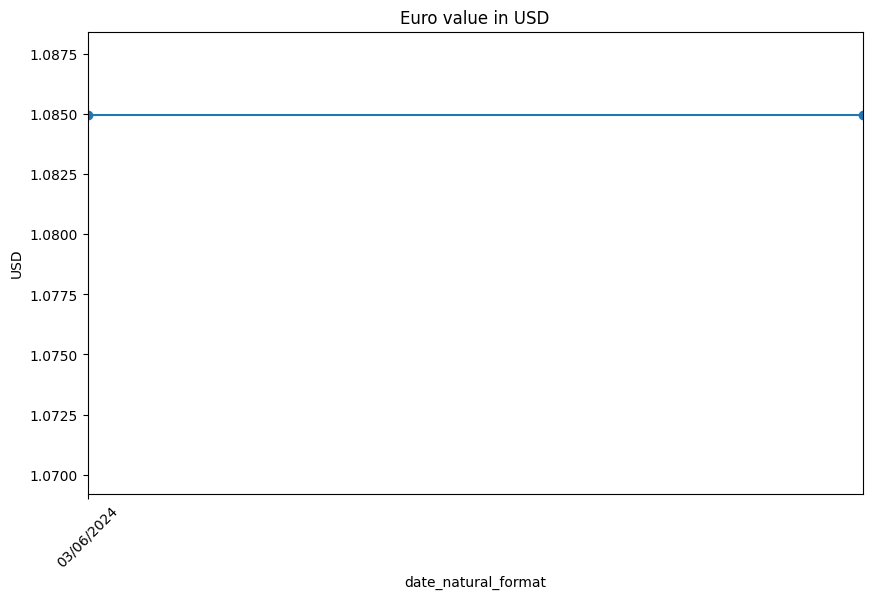

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

currency_df_euro = currency_df[currency_df["currency_name"].str.contains("Euro")]
currency_df["date_standard_format"] = pd.to_datetime(currency_df["date"], infer_datetime_format=True)

first_date = currency_df_euro["date_standard_format"].min()
last_date = currency_df_euro["date_standard_format"].max()
print("First date:", first_date)
print("Last date:", last_date)

# Create a complete DataFrame with date range
complete_dates = pd.date_range(start=first_date,
                               end=last_date, freq="D")
complete_df_euro = pd.DataFrame({"date_standard_format": complete_dates})
complete_df_euro = complete_df_euro.merge(currency_df_euro, on="date_standard_format", how="left")
complete_df_euro["in_dollars"] = complete_df_euro["in_dollars"].fillna(method="ffill")
complete_df_euro["date_natural_format"] = complete_df_euro["date_standard_format"].dt.strftime("%d/%m/%Y")
natural_first_date = complete_df_euro[complete_df_euro["date_standard_format"] == first_date]["date_natural_format"].values[0]
natural_last_date = complete_df_euro[complete_df_euro["date_standard_format"] == last_date]["date_natural_format"].values[0]

complete_df_euro.plot(x="date_natural_format", y="in_dollars", title="Euro value in USD", ylabel="USD", xlabel="date_natural_format", rot=45, marker = "o", legend=False, ax = ax)
#ax.set_xticks(start=first_date, end=last_date, freq="D")

In [40]:
natural_last_date

'17/06/2024'